# FOREX Prediction

In [2]:
import requests
import json
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf

2022-11-17 21:38:52.224219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from math import floor

from random import random

from numpy.random import default_rng

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [ ]:
popular_symbols = ['USD', 'EUR', 'JPY', 'GBP', 'CNY', 'AUD', 'CAD', 'CHF', 'HKD', 'SGD', 'SEK', 'KRW', 'NOK', 'NZD', 'INR', 'MXN', 'TWD', 'ZAR', 'BRL', 'DKK', 'PLN', 'THB', 'ILS', 'IDR', 'CZK', 'AED', 'TRY', 'HUF', 'CLP', 'SAR', 'PHP', 'MYR', 'COP', 'RUB', 'RON']

## Data Processing

### Raw Data Collection Using API

In [ ]:
# api_key = 'YknABlU4L9jZ3e7azGRzR71EHuvjxjuT'
api_key = 'YknABlU4L9jZ3e7azGRzR71EHuvjxjuT' + 'null'

date_of_collection = '2022-11-04'
base_currency = 'EUR'

data = []

for year in range(1999, 2023):
  s_date = f'{year}-01-01'
  e_date = f'{year}-12-31'

  response = requests.get(f'https://api.apilayer.com/exchangerates_data/timeseries?start_date={s_date}&end_date={e_date}', headers={ 'redirect': 'follow', 'apiKey':  api_key})
  data.append(response.json())

In [ ]:
with open('raw_data2.json', 'w') as f:
  json.dump(data, f)

In [ ]:
# api_key = 'YknABlU4L9jZ3e7azGRzR71EHuvjxjuT'
api_key = 'YknABlU4L9jZ3e7azGRzR71EHuvjxjuT' + 'null'

response = requests.get(f'https://api.apilayer.com/exchangerates_data/symbols', headers={ 'redirect': 'follow', 'apiKey':  api_key})

symbols_data = response.json()

In [ ]:
with open('raw_symbols2.json', 'w') as f:
  json.dump(symbols_data, f)

### Converting to Pandas Dataframe

In [ ]:
date_of_collection = '2022-11-04'

with open('raw_data.json', 'r') as f1:
  data = json.load(f1)
with open('raw_symbols.json', 'r') as f2:
  symbols_data = json.load(f2)

In [ ]:
all_rates = dict()
for d in data:
  all_rates.update(d['rates'])

dates = [d for d in list(all_rates.keys()) if d < date_of_collection]

In [ ]:
all_symbols = symbols_data['symbols']
symbols = list(all_symbols.keys())

In [ ]:
dataset = []

for date in dates:
  row = [date]
  for symbol in symbols:
    row.append(all_rates[date].get(symbol, None))
  dataset.append(row)


In [ ]:
base_columns = ['date', *symbols]
base_df = pd.DataFrame(np.asarray(dataset), columns=base_columns)

In [ ]:
columns = ['date'] + [f'{s1}-{s2}' for s1 in symbols for s2 in symbols]
df = base_df.drop(columns=symbols)

for s1 in popular_symbols:
  for s2 in popular_symbols:
    df[f'{s1}-{s2}'] = base_df[s1] / base_df[s2]
    print(s1, s2)

In [ ]:
df

In [ ]:
df.to_pickle('pop_data.pkl')

## Machine Learning With GRU

### Data Preparation

In [ ]:
df = pd.read_pickle('pop_data.pkl')
df

In [ ]:
exchanges = [f'{s1}-{s2}' for s1 in popular_symbols for s2 in popular_symbols if s1 != s2]

for ex in exchanges:
    df[ex]

In [ ]:
df_norm = df.copy()
norm_factors = dict()

padding = 0.05

def scale_to_0_1(col, extent):
  return (col -  extent['min']) / (extent['max'] - extent['min']) * (1 - 2 * padding) + padding

def scale_from_0_1(col, extent):
  return (col - padding) / (1 - 2 * padding) * (extent['max'] - extent['min']) + extent['min']

for ex in exchanges:
  norm_factors[ex] = {
    'min': df_norm[ex].min(),
    'max': df_norm[ex].max()
  }
  df_norm[ex] = scale_to_0_1(df_norm[ex], norm_factors[ex])

In [ ]:
with open('norm_factors.json', 'w') as f:
  json.dump(norm_factors, f)

df_norm.to_pickle('pop_data_norm.pkl')

### Creating Training Data

In [ ]:
df_norm = pd.read_pickle('pop_data_norm.pkl')

In [ ]:
input_timeframe = 90
output_timeframe = 14

X_train_raw = []
y_train_raw = []

for k, ex in enumerate(exchanges):
    if k % floor(len(exchanges) / (100 / 5)) == 0:
        print(f'k: {k}, {k / len(exchanges) * 100}% done')
    
    training_set = df_norm[df_norm[ex].notnull()][ex].to_numpy().reshape((1, -1))

    l = training_set.shape[1] - output_timeframe - input_timeframe
    for i in range(input_timeframe, training_set.shape[1] - output_timeframe):
        if random() < 1 / 45:
            X_train_raw.append(training_set[0, i-input_timeframe:i])
            y_train_raw.append(training_set[0, i:i+output_timeframe])

In [ ]:
print(len(X_train_raw), len(y_train_raw))

In [ ]:
with open('training_data_X.pkl', 'wb') as f:
    pickle.dump(X_train_raw, f)
with open('training_data_y.pkl', 'wb') as f:
    pickle.dump(y_train_raw, f)

### Training Data Preparation and Sampling

In [ ]:
with open('training_data_X.pkl', 'rb') as f:
    X_train_raw = pickle.load(f)
with open('training_data_y.pkl', 'rb') as f:
    y_train_raw = pickle.load(f)

In [ ]:
X_train_raw = np.asarray(X_train_raw).astype('float32')
y_train_raw = np.asarray(y_train_raw).astype('float32')
print(X_train_raw.shape, y_train_raw.shape)

# X_test_raw = np.asarray(X_test_raw).astype('float32')
# y_test = np.asarray(y_test).astype('float32')
# print(X_test_raw.shape, y_test.shape)

In [ ]:
N = 200_000

rng = default_rng()
indices = rng.choice(X_train_raw.shape[0], size=min(N, X_train_raw.shape[0]), replace=False)

print(len(indices))

In [ ]:
X_train = X_train_raw[indices]
X_train = np.reshape(X_train, (*X_train.shape, 1))
y_train = y_train_raw[indices]

print(X_train.shape, y_train.shape)

# X_test = np.reshape(X_test_raw, (*X_test_raw.shape, 1))
# print(X_test.shape, y_test.shape)

In [ ]:
with open('training_data.npy', 'wb') as f:
    np.save(f, X_train)
    np.save(f, y_train)

### Machine Learning Using LSTM

In [ ]:
with open('training_data.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)

print(X_train.shape, y_train.shape)

In [ ]:
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(input_timeframe, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(units=32))
model.add(Dropout(0.4))

model.add(Dense(units=output_timeframe))

model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=3, batch_size=2048)

### Results

In [ ]:
# pred_X_test = model.predict(X_test)
pred_X_train = model.predict(X_train[:2000])

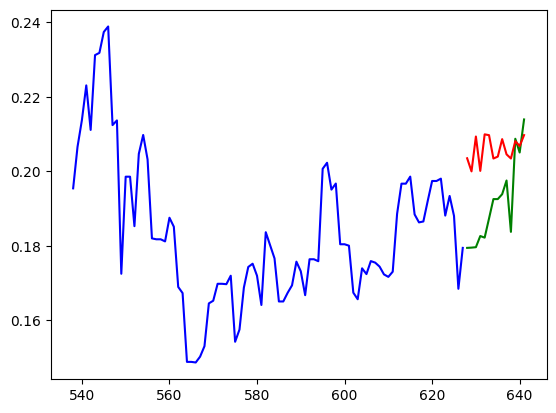

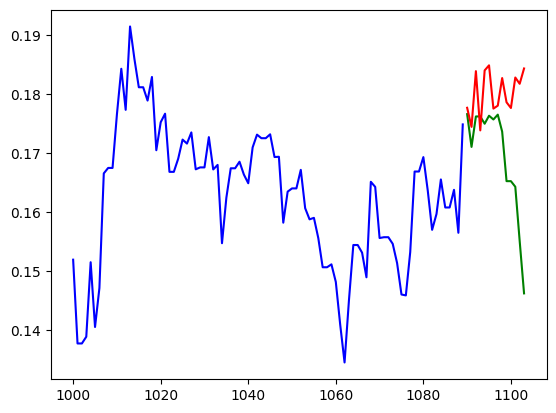

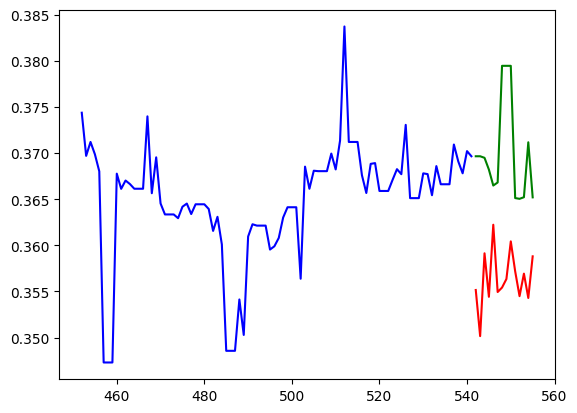

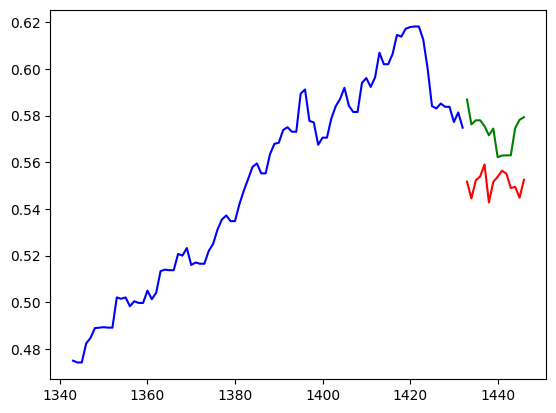

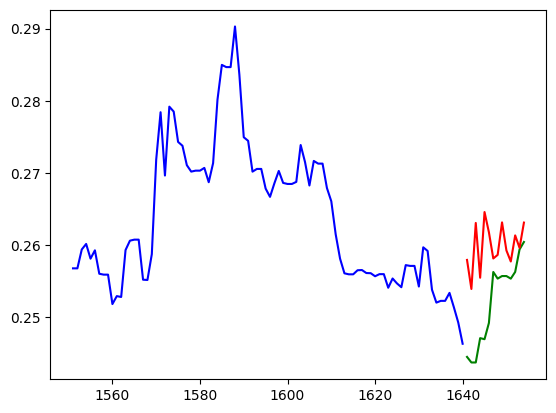

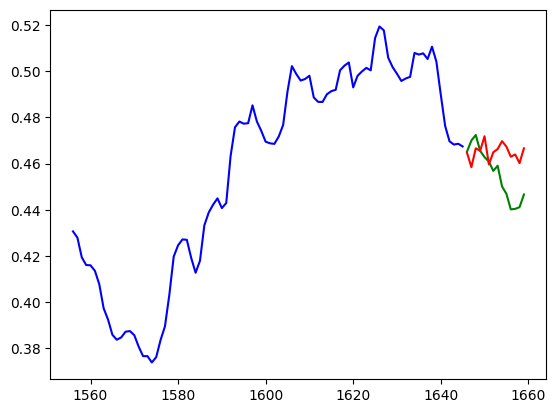

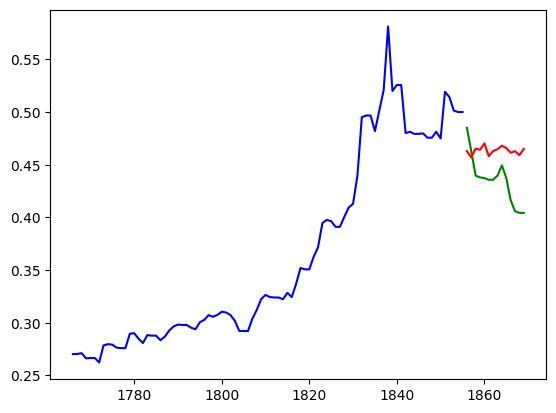

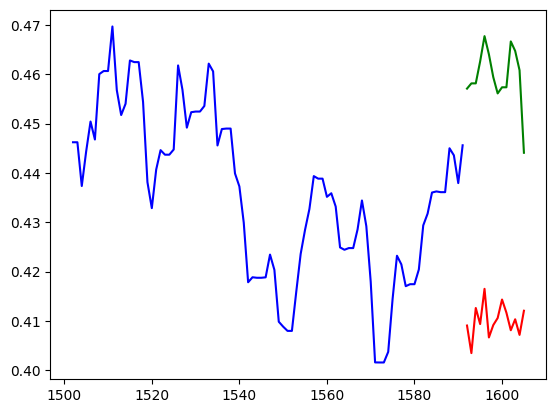

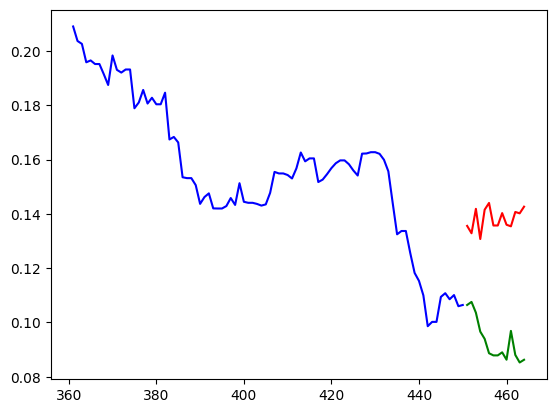

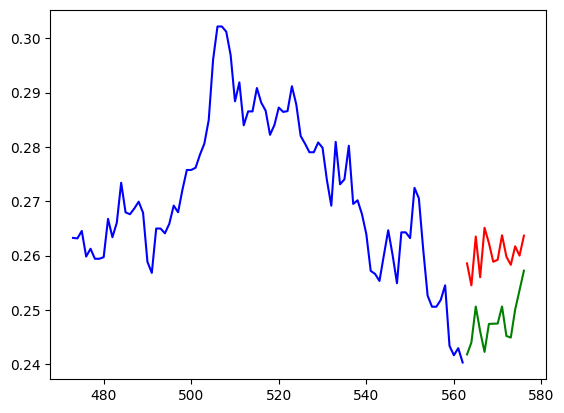

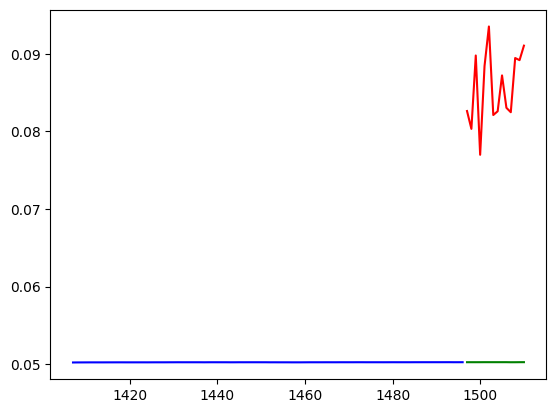

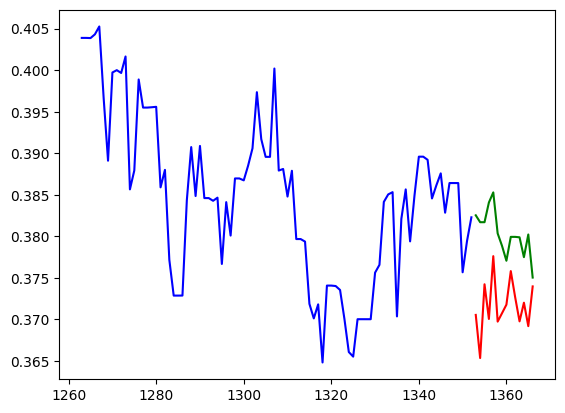

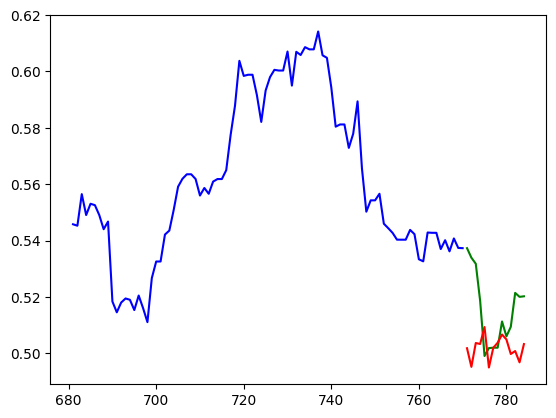

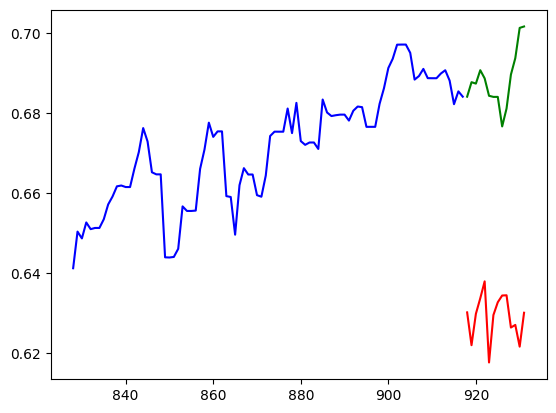

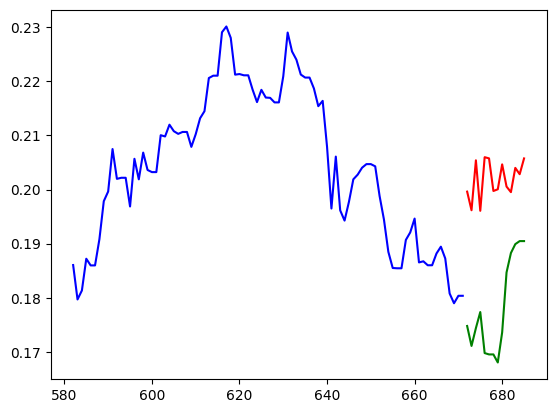

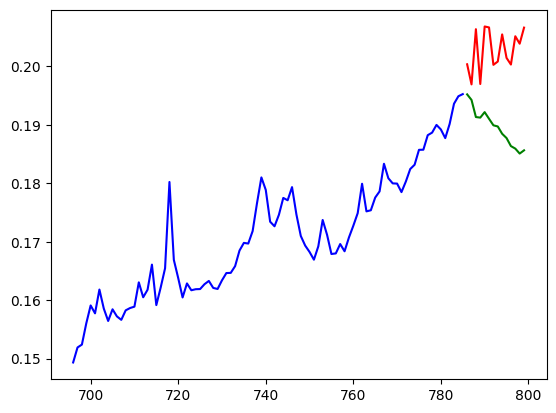

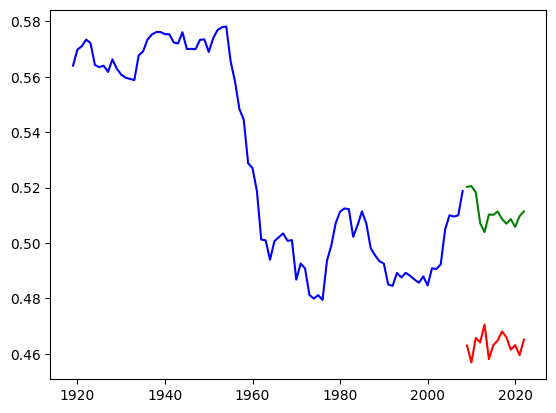

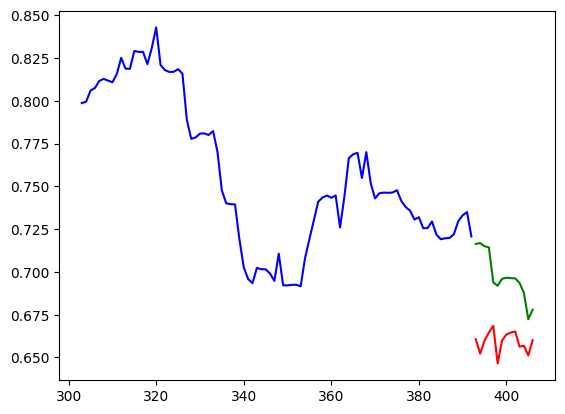

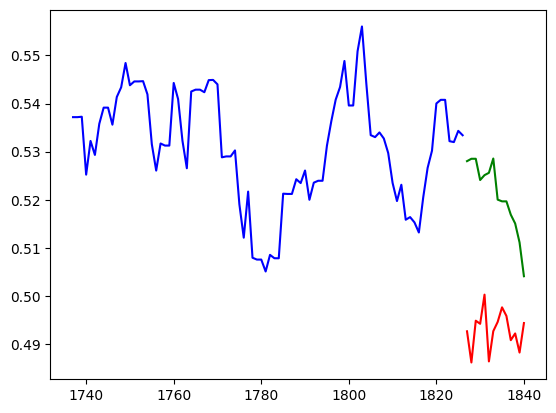

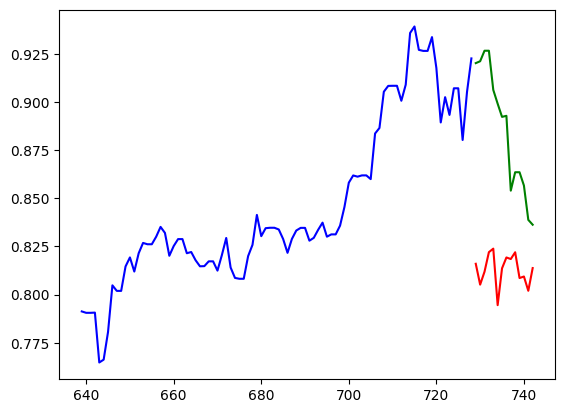

In [186]:
for i in rng.choice(2000, size=20, replace=False):
    # plt.plot(range(i, i + input_timeframe + output_timeframe), training_set[0, i:i+input_timeframe+output_timeframe])
    plt.plot(range(i, i + input_timeframe), X_train[i], color='blue')
    plt.plot(range(i + input_timeframe, i + input_timeframe + output_timeframe), y_train[i], color='green')
    plt.plot(range(i + input_timeframe, i + input_timeframe + output_timeframe), pred_X_train[i], color='red')
    plt.show()

### Saving the Model

In [ ]:
model.save("pred_model.h5")

In [5]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'pred_model_tfjs')

### Loading the Model

In [4]:
model = tf.keras.models.load_model('pred_model.h5')